In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve


%matplotlib inline

In [2]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='red', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [3]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [6]:
df = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

## Предобработка дата-сета

### 1.1. Выбросы 

<b> Current Loan Amount </b> явно содержит выбросы. При этом все клиенты, которые имеют значении признака 9999999.0 не просрочили выплаты. Попробуем на основании этого создать новую категориальную переменную переменную. Сразу будем вносить изменения к тренировочный и тестовый наборы данных.

In [7]:
round(df['Current Loan Amount'].describe())

count        7500.0
mean     11873177.0
std      31926123.0
min         11242.0
25%        180169.0
50%        309573.0
75%        519882.0
max      99999999.0
Name: Current Loan Amount, dtype: float64

In [8]:
df.loc[df['Current Loan Amount'] == 99999999.0, 'Credit Default'].value_counts()

0    870
Name: Credit Default, dtype: int64

In [9]:
def cat_loan_feature(df):
    df['Cat Loan'] = 1
    df.loc[df['Current Loan Amount'] == 99999999.0, 'Cat Loan'] = 0
    df['Cat Loan'] = df['Cat Loan'].astype('category')
    return df

df = cat_loan_feature(df)
df_test = cat_loan_feature(df_test)

Нам всё еще нужно как-то обработать данные значения признака. Мне показалось логичнее всего просто приравнять данный признак к текущему кредитному балансу

In [10]:
def current_loan(df):
    df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Credit Balance']
    df.loc[df['Current Loan Amount'] < 10000, 'Current Loan Amount'] = df['Current Loan Amount'].mean()
    return df

df = current_loan(df)
df_test = current_loan(df_test)

C <b> Credit Score </b> похожая ситуация. Мы видим подозрительно большие максимальные значения. При слишком высоких значениях данного признака все наши клиенты внезапно перестают возвращать кредит. Поскольку клиенты с такими значения в списке "плохих" - выставим им минимальный рейтинг по выборке

In [11]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [12]:
df['Credit Default'].loc[df['Credit Score'] > 850].value_counts()

1    400
Name: Credit Default, dtype: int64

In [13]:
def cat_credit_feature(df):
    df['Cat Credit Score'] = 0
    df.loc[df['Credit Score'] > 850, 'Cat Credit Score'] = 1
    df['Cat Credit Score'] = df['Cat Credit Score'].astype('category')
    #df.loc[df['Credit Score'] > 850, 'Credit Score'] = df['Credit Score'].min() - 1
    df.loc[df['Credit Score'] > 850, 'Credit Score'] = df['Credit Score'].quantile(0.25)
    return df

df = cat_credit_feature(df)
df_test = cat_credit_feature(df_test)

In [14]:
df.loc[df['Maximum Open Credit'] < 1000, 'Maximum Open Credit'] = df.loc[df['Maximum Open Credit'] < 1000, 'Current Loan Amount']
df_test.loc[df_test['Maximum Open Credit'] < 1000, 'Maximum Open Credit'] = df_test.loc[df_test['Maximum Open Credit'] < 1000, 'Current Loan Amount']

### 1.2. Заполнение пропусков

#### Annual Income и Credit Score

Поработаем с признаками Annual Income и Credit Score. Мы видим, что у них одинаковое число пропусков. Посмотрим сколько у нас наблюдений, в которых оба признака пропущены одновременно.

In [15]:
df[df['Annual Income'].isna() & df['Credit Score'].isna()].shape

(1557, 19)

Мы видим, что эти признаками всегда пропущены парно. Теперь проверим соотношение классов целевой переменной для наблюдений, где пропущены данные значения

In [16]:
df['Credit Default'][df['Annual Income'].isna() & df['Credit Score'].isna()].value_counts()

0    1028
1     529
Name: Credit Default, dtype: int64

Сравним с наблюдениями, где данные признаки заполнены

In [17]:
df['Credit Default'][df['Annual Income'].notna() & df['Credit Score'].notna()].value_counts()

0    4359
1    1584
Name: Credit Default, dtype: int64

Мы видим, соотношение классов различается достаточно сильно, проверим значимость данного различия с помощью Хи-Квадрата. Нулевой гипотезой в нашем случее будет утверждение, что частота появления класса 1 или 0 между двумя выборками одинакова.

In [18]:
table = df[['Annual Income', 'Credit Default']].copy()
table['id'] = 1

In [19]:
table['Annual Income'].loc[df['Annual Income'].notna()] = 1
table['Annual Income'].loc[df['Annual Income'].isna()] = 0

C:\Users\Pavel\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
table = table.pivot_table(values='id', index='Annual Income', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Annual Income,,
0.0,1028,529
1.0,4359,1584


In [21]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

1.0809288763223263e-08

P-value слишком маленькое, следовательно наша гипотеза отвергается. Значит, различие между частотой классов в двух выборках важна. Из этого мы делаем вывод, что нельзя просто взять, и заполнить данные пропуски средним значением по выборке <br>
Процент просрочки в в наблюдениях с пропусками выше, чем в целом по выборке. Попробуем сравнить его с наблюдениями из первой квартили (самые "бедные" потребители)

In [22]:
round(df['Annual Income'].describe())

count        5943.0
mean      1366392.0
std        845339.0
min        164597.0
25%        844341.0
50%       1168386.0
75%       1640137.0
max      10149344.0
Name: Annual Income, dtype: float64

In [23]:
df['Credit Default'][df['Annual Income'] <= 844341].value_counts()

0    999
1    487
Name: Credit Default, dtype: int64

In [24]:
chi2, p, dof, expected = chi2_contingency([[1028, 529], [999, 487]], correction=False)
p 

0.4817939955112345

In [25]:
round(df['Credit Score'].describe())

count    5943.0
mean      720.0
std        27.0
min       585.0
25%       711.0
50%       727.0
75%       740.0
max       751.0
Name: Credit Score, dtype: float64

In [26]:
df['Credit Default'][(df['Credit Score'] <= 702) & (df['Credit Score'] > 585)].value_counts()

0    726
1    382
Name: Credit Default, dtype: int64

In [27]:
chi2, p, dof, expected = chi2_contingency([[1028, 529], [726, 382]], correction=False)
p 

0.7881572031057479

Мы видим, что распределение классов между "бедными" клиентами, и клиентами с пропущенными данными соразмерно.
Поэтому пропуски мы заполним средними значениеми из первой квартили.

In [28]:
# annual_income = df['Annual Income'].loc[df['Annual Income'] < df['Annual Income'].quantile(0.25)].mean()
# credit_score = df['Credit Score'].loc[df['Credit Score'] < df['Credit Score'].quantile(0.25)].mean()

In [29]:
annual_income = df['Annual Income'].loc[df['Annual Income'] < df['Annual Income'].quantile(0.25)].mean()
credit_score = df['Credit Score'].loc[(df['Credit Score'] <= 702) & (df['Credit Score'] > 585)].mean()


In [30]:
df['Annual Income'].loc[df['Annual Income'].isna()] = annual_income
df['Credit Score'].loc[df['Credit Score'].isna()] = credit_score

df_test['Annual Income'].loc[df_test['Annual Income'].isna()] = annual_income
df_test['Credit Score'].loc[df_test['Credit Score'].isna()] = credit_score

#### Years in current job

In [31]:
df['Years in current job'] = df['Years in current job'].astype('category')

In [32]:
df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [33]:
df.loc[df['Years in current job'].isna()].head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Cat Loan,Cat Credit Score


#### Months since last delinquent

In [34]:
df.loc[df['Months since last delinquent'] == 0].shape

(18, 19)

Мы видим всего 18 наблюдений без просрочек кредита. Скорее всего подразумевается, что Nan - это отсутствие просрочек, заменим пропуски нулями. В дальнейшем мы увидим, что этот признак можно убрать из модели.

In [35]:
df['Months since last delinquent'].loc[df['Months since last delinquent'].isna()] = 0

df_test['Months since last delinquent'].loc[df_test['Months since last delinquent'].isna()] = 0

#### Bankruptcies

пропущенных значений мало, проставим 0

In [36]:
df['Bankruptcies'].loc[df['Bankruptcies'].isna()] = 0

Добавим несколько новый признаков, составленных их известных.

In [37]:
def new_feature(df):
    df['Per Account'] = df['Maximum Open Credit'] / df['Number of Open Accounts']
    return df

df = new_feature(df)
df_test = new_feature(df_test)

In [38]:
def new_coef(df):
    df['coef'] = df['Annual Income'] / (df['Monthly Debt'] * 12)
    return df

df = new_coef(df)
df_test = new_coef(df_test)

## Строим модель

In [39]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(confusion_matrix(y_test_true, y_test_pred))

In [40]:
data = df.copy()

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7500 non-null category
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                 

Я решил использовать LightGBM, поэтому мне не нужно использовать dummy переменные, достаточно просто пометить нужны признаки как категориальные

In [42]:
features = ['Home Ownership', 'Annual Income', 'Years in current job', 
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Per Account', 'coef',
       'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Cat Credit Score', 'Cat Loan'] 
# features = ['Home Ownership', 'Annual Income', 'Years in current job', 
#        'Number of Open Accounts', 'Years of Credit History',
#        'Maximum Open Credit', 
#        'Purpose', 'Term',
#        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#        'Credit Score', 'Cat Credit Score', 'Cat Loan'] 
  
cat_features = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Cat Credit Score', 'Cat Loan']
    
target = 'Credit Default'

In [43]:
for colname in cat_features:
    data[colname] = data[colname].astype('category')

for colname in cat_features:
    df_test[colname] = df_test[colname].astype('category')    


In [44]:
X = data[features]
y = data[target]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=10, stratify=y)

In [46]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

C:\Users\Pavel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
C:\Users\Pavel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0    4040
1    3170
Name: Credit Default, dtype: int64

In [47]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

In [48]:
model_lgbm = lgbm.LGBMClassifier(random_state=1,
                                max_depth=4,
                                num_leaves=16,
                                n_estimators=1000,
                                reg_alpha=25,
                                learning_rate=0.9,
                                
                               )

In [49]:
model_lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.9, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=16, objective=None,
               random_state=1, reg_alpha=25, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [50]:
y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

y_train_pred_proba = model_lgbm.predict_proba(X_train)
y_test_pred_proba = model_lgbm.predict_proba(X_test)

In [51]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      4040
           1       0.75      0.62      0.68      3170

    accuracy                           0.74      7210
   macro avg       0.75      0.73      0.73      7210
weighted avg       0.75      0.74      0.74      7210

TEST

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1347
           1       0.52      0.58      0.55       528

    accuracy                           0.73      1875
   macro avg       0.67      0.68      0.68      1875
weighted avg       0.74      0.73      0.73      1875

CONFUSION MATRIX

[[1060  287]
 [ 222  306]]


In [52]:
fpr, tpr, threshholds = roc_curve(y_test, y_test_pred_proba[:,1])

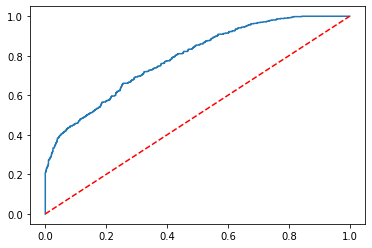

In [53]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')

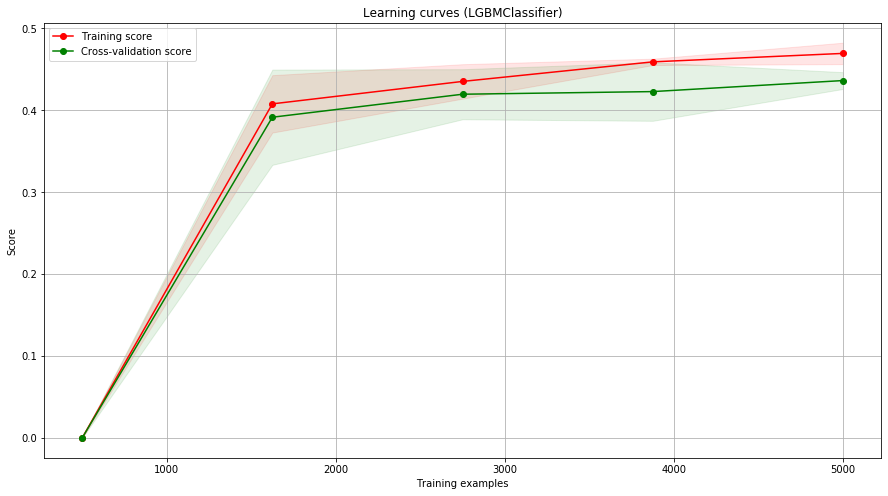

In [54]:
show_learning_curve_plot(model_lgbm, X, y)

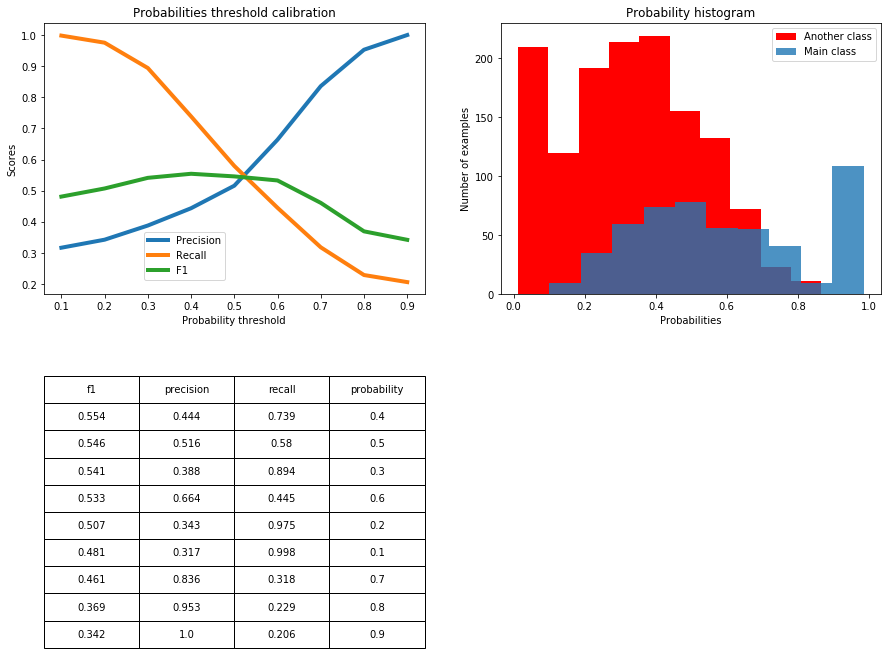

In [55]:
show_proba_calibration_plots(y_test_pred_proba[:, 1], y_test)

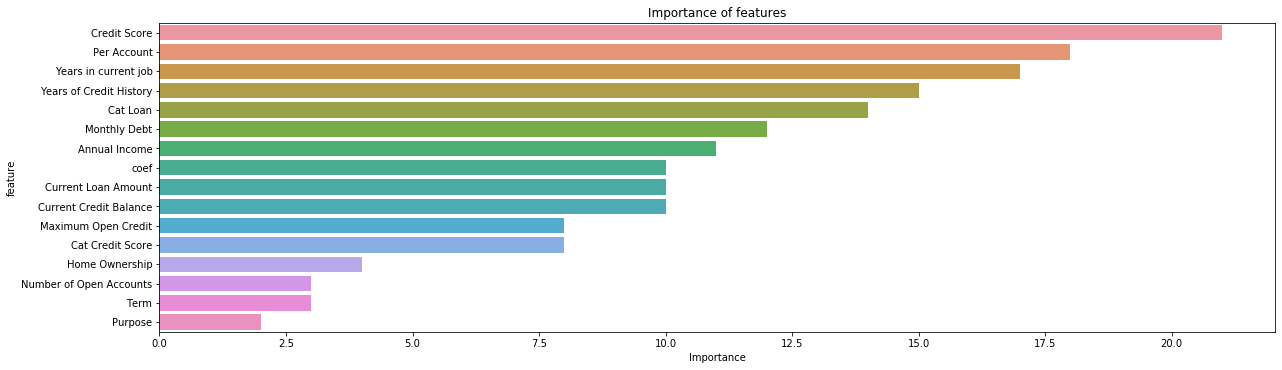

In [56]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_)

Наилучший результат получаем при пороге 0.5. Делаем предсказания на тестовых данных.

In [57]:
df_test['Credit Default'] = model_lgbm.predict(df_test[features])

In [58]:
with open('model', 'wb') as file:
    pickle.dump(model_lgbm, file)

In [59]:
df_test.to_csv('Babalich_prediction.csv',  index=False, encoding='utf-8')

Итоговый файл содержит исходных датасет, дополненный предсказанной целевой переменной - <b> Credit Default </b>